# Calibration of a 2 theta arm with a Pilatus 300kw detector



A prior manual calibration (using pyFAI-calib2) has been performed on select images. Those images had ring each in them (1,3,5,7,9 th rings). The control points extrated during this initial calibration has been used as a starting point for this calibration. Then more images have been added to make the model more robust.

from http://www.silx.org/doc/pyFAI/dev/usage/tutorial/Goniometer/Rotation-Pilatus100k/Multi120_Pilatus100k.html


In [1]:

#folder with poni and raw data files and csv files
raw_alignment_folder = "H:\\Data\\ProjectsandData\\LiXRD\\open cell\\cone cell\\20190329\\LaB6\\images\\imgs"

#size of imgs
w = 1475
h = 195


wavelength = 8.85601409974337e-11

In [15]:
# Initialization of the plotting library to be used with the jupyter notebook


import nbformat

import os
#Loading of a few libraries
import os
import glob
import random
import fabio
import pyFAI
from pyFAI.goniometer import GeometryTranslation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#making sure we are in the right folder and seeing your files
all_files = os.listdir(raw_alignment_folder)
print([os.path.basename(i) for i in all_files])

['b_toney_LaB6cal_scan1_0000.raw', 'b_toney_LaB6cal_scan1_0001.raw', 'b_toney_LaB6cal_scan1_0002.raw', 'b_toney_LaB6cal_scan1_0003.npt', 'b_toney_LaB6cal_scan1_0003.poni', 'b_toney_LaB6cal_scan1_0003.raw', 'b_toney_LaB6cal_scan1_0003.tif', 'b_toney_LaB6cal_scan1_0004.raw', 'b_toney_LaB6cal_scan1_0005.raw', 'b_toney_LaB6cal_scan1_0006.raw', 'b_toney_LaB6cal_scan1_0007.raw', 'b_toney_LaB6cal_scan1_0008.raw', 'b_toney_LaB6cal_scan1_0009.npt', 'b_toney_LaB6cal_scan1_0009.poni', 'b_toney_LaB6cal_scan1_0009.raw', 'b_toney_LaB6cal_scan1_0009.tif', 'b_toney_LaB6cal_scan1_0010.raw', 'b_toney_LaB6cal_scan1_0011.raw', 'b_toney_LaB6cal_scan1_0012.raw', 'b_toney_LaB6cal_scan1_0013.raw', 'b_toney_LaB6cal_scan1_0014.raw', 'b_toney_LaB6cal_scan1_0015.npt', 'b_toney_LaB6cal_scan1_0015.poni', 'b_toney_LaB6cal_scan1_0015.raw', 'b_toney_LaB6cal_scan1_0015.tif', 'b_toney_LaB6cal_scan1_0016.raw', 'b_toney_LaB6cal_scan1_0017.raw', 'b_toney_LaB6cal_scan1_0018.raw', 'b_toney_LaB6cal_scan1_0019.raw', 'b_toney_L

In [16]:
#function to read the raw files that SSRL saves
def read_raw(fn, w, h):
    #try:
    with open(fn, 'r') as f:
        img = np.fromfile(f, dtype=np.int32)
    img = np.reshape(img, (h,w), order='C')
    return img
    #except:
    """print("Error reading file: %s" % fn)
        return(None)"""

List of images: b_toney_LaB6cal_scan1_0000.raw, b_toney_LaB6cal_scan1_0001.raw, b_toney_LaB6cal_scan1_0002.raw, b_toney_LaB6cal_scan1_0003.raw, b_toney_LaB6cal_scan1_0004.raw, b_toney_LaB6cal_scan1_0005.raw, b_toney_LaB6cal_scan1_0006.raw, b_toney_LaB6cal_scan1_0007.raw, b_toney_LaB6cal_scan1_0008.raw, b_toney_LaB6cal_scan1_0009.raw, b_toney_LaB6cal_scan1_0010.raw, b_toney_LaB6cal_scan1_0011.raw, b_toney_LaB6cal_scan1_0012.raw, b_toney_LaB6cal_scan1_0013.raw, b_toney_LaB6cal_scan1_0014.raw, b_toney_LaB6cal_scan1_0015.raw, b_toney_LaB6cal_scan1_0016.raw, b_toney_LaB6cal_scan1_0017.raw, b_toney_LaB6cal_scan1_0018.raw, b_toney_LaB6cal_scan1_0019.raw, b_toney_LaB6cal_scan1_0020.raw, b_toney_LaB6cal_scan1_0021.raw, b_toney_LaB6cal_scan1_0022.raw, b_toney_LaB6cal_scan1_0023.raw, b_toney_LaB6cal_scan1_0024.raw, b_toney_LaB6cal_scan1_0025.raw, b_toney_LaB6cal_scan1_0026.raw, b_toney_LaB6cal_scan1_0027.raw, b_toney_LaB6cal_scan1_0028.raw, b_toney_LaB6cal_scan1_0029.raw, b_toney_LaB6cal_scan1_00

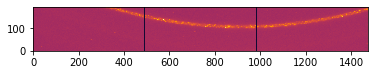

In [17]:
#loading of the list of raw files
os.chdir(raw_alignment_folder)
#print(os.listdir())
raw_files = glob.glob("*LaB6cal*.raw")
#print(raw_files)
raw_files.sort()
print("List of images: " + ", ".join(raw_files) + "." + os.linesep)


#displays last image (might be upside down which is okay)
fimg = read_raw(raw_files[-3], w, h)
jupyter.display(fimg)



In [18]:
#Definition of the goniometer translation function:
# The detector rotates vertically, around the horizontal axis, i.e. rot2, 
# allows some rotation of rot 1 and rot 3, but these are usually small if the arm/motor is functioning as it should


goniotrans = GeometryTranslation(param_names = ["dist", 
                                                "poni1",
                                                "poni2",
                                                 "rot1", "rot1_scale",
                                                 "rot2_offset", "rot2_scale", 
                                                 "rot3", "rot3_scale"],
                                  dist_expr="dist", 
                                  poni1_expr="poni1",
                                  poni2_expr="poni2", 
                                  rot1_expr="rot1_scale * pos + rot1", 
                                  rot2_expr="rot2_scale * pos + rot2_offset", 
                                  rot3_expr="rot3_scale * pos + rot3")

#gets angle from csv file
def get_angle(basename):
    """Takes the basename (b_toney_scanname_scan1_0001 ) and returns the angle of the detector by looking up in the csv file"""
    #pretty sure there is a more concise way to extract this info 
    import csv
    group     = str(basename.split("_")[1])
    #print(group)
    
    #data = pd.read_csv(fil,delimiter="\t")
    
    #parses and puts file name back together in case there were _ in the file name
    scan_parse = (basename.split("_")[2:-2])
    #print(scan_parse)
    scan_name = ""
    for i, p in enumerate(list(scan_parse)):
        if i == 0 :
            scan_name = scan_name + p
        if i >= 1:
            scan_name = scan_name + "_" + p
    #print(scan_name)
    scan_no   = str(basename.split("_")[-2])
    img_no    = int((basename.split("_")[-1]).split(".")[0])
    
    filename  = scan_name + "_" + scan_no
    angle = filename
    #print(filename)
    #print(img_no)
    csvfile = filename + ".csv"
    with open(csvfile, 'r') as csvfile:
        csvfile = csv.reader(csvfile)
        for i, row in enumerate(csvfile):
            #print(i)
            #print(row[1])
            if i == (img_no + 1):
                ##############################check here that correct column from csv file is used: 1 for second column, 2 for the third
                angle = float(row[1])
                #print(angle)
    return angle

print("angle =", get_angle(raw_files[-1]))


angle = 22.0


In [19]:
#Definition of the detector, its mask, the calibrant

#mask1 = fabio.open("deviation-mask.edf").data
#mask2 = fabio.open("minimum-mask.edf").data
#mask = numpy.logical_or(mask1, mask2)


pilatus = pyFAI.detector_factory("Pilatus300kw")
print(pilatus)
#pilatus.mask = mask
    
LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
LaB6.wavelength = wavelength

Detector Pilatus 300kw	 PixelSize= 1.720e-04, 1.720e-04 m


In [20]:
#Definition of the geometry refinement: the parameter order is the same as the param_names

#adjust the param hints
param = {"dist":0.8, 
         "poni1":0.02, 
         "poni2":0.04, 
         "rot1":0,
         "rot1_scale":0,
         "rot2_offset":0,
         "rot2_scale": np.pi/180., # rot2 is in radians, while the motor position is in degrees
         "rot3":0,
         "rot3_scale":0
         
        }
#Defines the bounds for some variables
bounds = {#"dist": (0.6, 1.3),
          #"rot1": (-0.3, 0.03),
          #"rot2_offset": (-0.1, 0.1),
          #"rot2_scale": (numpy.pi/180., numpy.pi/180.)
          #strict bounds on the scale: we expect the gonio to be precise
         }
gonioref = GoniometerRefinement(param, #initial guess
                                bounds=bounds,
                                pos_function=get_angle,
                                trans_function=goniotrans,
                                detector=pilatus,
                                wavelength=wavelength)
print("Empty refinement object:")
print(gonioref)

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .


In [21]:
#Let's populate the goniometer refinement object with all control point files:
print(os.getcwd())
ponis = glob.glob("*.poni")
ponis.sort()
print(ponis)
for fn in ponis:
    base = os.path.splitext(fn)[0]
    print(base)
    fimg = read_raw(base + ".raw", w,h)
    #jupyter.display(fimg)
    sg = gonioref.new_geometry(base, image=fimg, metadata=base, control_points=base+".npt", geometry=fn, calibrant=LaB6)
    print(base, "Angle:", sg.get_position())
    print(sg.geometry_refinement)
    print
    

print("Filled refinement object:")
print(gonioref)


H:\Data\ProjectsandData\LiXRD\open cell\cone cell\20190329\LaB6\images\imgs
['b_toney_LaB6cal_scan1_0003.poni', 'b_toney_LaB6cal_scan1_0009.poni', 'b_toney_LaB6cal_scan1_0015.poni', 'b_toney_LaB6cal_scan1_0020.poni', 'b_toney_LaB6cal_scan1_0024.poni', 'b_toney_LaB6cal_scan1_0029.poni', 'b_toney_LaB6cal_scan1_0035.poni']
b_toney_LaB6cal_scan1_0003
b_toney_LaB6cal_scan1_0003 Angle: 12.1429
Detector Pilatus 300kw	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 8.856014e-11m
SampleDetDist= 6.953082e-01m	PONI= 1.583632e-01, -1.583078e-01m	rot1=-0.409246  rot2= 0.024772  rot3= -0.000000 rad
DirectBeamDist= 758.127mm	Center: x=832.975, y=1029.894 pix	Tilt=23.489 deg  tiltPlanRotation= 3.563 deg
b_toney_LaB6cal_scan1_0009
b_toney_LaB6cal_scan1_0009 Angle: 16.4286
Detector Pilatus 300kw	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 8.856014e-11m
SampleDetDist= 8.671492e-01m	PONI= 3.027672e-01, 1.923934e-02m	rot1=-0.143376  rot2= -0.029699  rot3= -0.000038 rad
DirectBeamDist= 876.526mm	Center: x

()


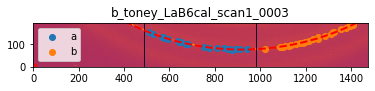

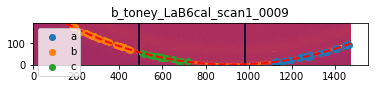

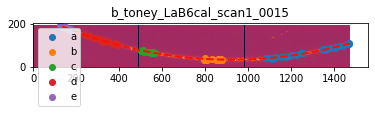

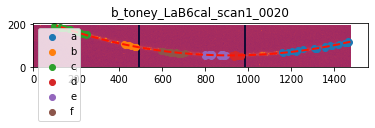

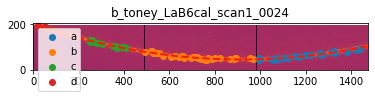

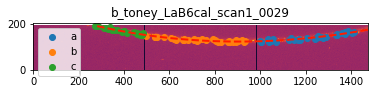

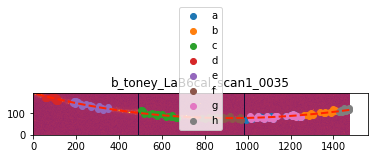

In [22]:
#Display all images with associated calibration:
print(np.shape(gonioref.single_geometries.values()))
for sg in gonioref.single_geometries.values():
    print(sg)
    #print(sg.geometry_refinement.data)
    jupyter.display(sg=sg)

In [23]:
# Initial refinement of the goniometer model with 5 dof
gonioref.refine2()

Cost function before refinement: 0.00131743904396736
[0.8        0.02       0.04       0.         0.         0.
 0.01745329 0.         0.        ]
     fun: 5.327915732921469e-07
     jac: array([-1.93082883e-10, -4.14610746e-07, -9.78517463e-08,  4.75723567e-08,
        1.65513854e-06, -3.62357156e-07, -7.96890770e-06,  4.97379915e-14,
        2.41584530e-13])
 message: 'Optimization terminated successfully.'
    nfev: 370
     nit: 33
    njev: 33
  status: 0
 success: True
       x: array([ 9.02043425e-01,  1.44449642e-02,  1.04689211e-01, -5.90107448e-02,
        4.57976662e-06,  1.60869533e-04,  1.74449032e-02,  1.04259228e-09,
        2.52880194e-10])
Cost function after refinement: 5.327915732921469e-07
GonioParam(dist=0.9020434246795056, poni1=0.014444964167442233, poni2=0.10468921131445227, rot1=-0.05901074481465603, rot1_scale=4.579766621595594e-06, rot2_offset=0.00016086953262062106, rot2_scale=0.01744490323138065, rot3=1.0425922810067276e-09, rot3_scale=2.5288019374720074e-

array([ 9.02043425e-01,  1.44449642e-02,  1.04689211e-01, -5.90107448e-02,
        4.57976662e-06,  1.60869533e-04,  1.74449032e-02,  1.04259228e-09,
        2.52880194e-10])

In [24]:
# This function adds new images to the pool of data used for the refinement.
# A set of new control points are extractred and a refinement step is performed at each iteration
# The last image of the serie is displayed 

def optimize_with_new_images(list_images, pts_per_deg=1):
    sg = None
    for fname in list_images:
        print(fname)
        base = os.path.splitext(fname)[0]
        fimg = read_raw(base + ".raw", w, h)
        #print(fimg.shape)
        #print(gonioref.single_geometries)
        if base in gonioref.single_geometries:
            continue
        #print(fimg)
        sg = gonioref.new_geometry(base, image=fimg, metadata=base,#geometry=fn,
                                   calibrant=LaB6)
        #jupyter.display(sg=sg)
        print(sg.extract_cp(pts_per_deg=pts_per_deg))
    gonioref.refine2()
    if sg: 
        sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
        jupyter.display(sg=sg)


b_toney_LaB6cal_scan1_0048.raw
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 2 groups of points:
# i ring 10: 16 points
# j ring 11: 23 points
b_toney_LaB6cal_scan1_0059.raw
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
# k ring 14: 22 points
b_toney_LaB6cal_scan1_0031.raw
ControlPoints instance containing 0 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 0 groups of points:
b_toney_LaB6cal_scan1_0044.raw
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
# l ring 9: 25 points
b_toney_LaB6cal_scan2_0006.raw
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 2 groups 

ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
#bh ring 5: 7 points
b_toney_LaB6cal_scan1_0026.raw
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 2 groups of points:
#bi ring 4: 16 points
#bj ring 5: 7 points
b_toney_LaB6cal_scan1_0066.raw
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 2 groups of points:
#bk ring 17: 20 points
#bl ring 18: 3 points
b_toney_LaB6cal_scan2_0010.raw
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
#bm ring 2: 13 points
b_toney_LaB6cal_scan1_0042.raw
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 

ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 2 groups of points:
#dc ring 9: 20 points
#dd ring 10: 10 points
b_toney_LaB6cal_scan1_0033.raw
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
#de ring 6: 7 points
b_toney_LaB6cal_scan1_0051.raw
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 1 groups of points:
#df ring 12: 23 points
b_toney_LaB6cal_scan1_0036.raw
ControlPoints instance containing 2 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing 2 groups of points:
#dg ring 6: 23 points
#dh ring 7: 6 points
b_toney_LaB6cal_scan1_0037.raw
ControlPoints instance containing 1 group of point:
LaB6 Calibrant with 75 reflections at wavelength 8.85601409974337e-11
Containing

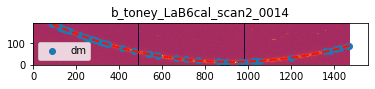

In [25]:
 # Append all other images

all_images = glob.glob("b_toney*.raw")
random.shuffle(all_images)
optimize_with_new_images(all_images)
print("Total number of images:", len(gonioref.single_geometries) )

In [26]:
# Check the calibration of the first and the last image with rings

print("First & last rings")


print("Total number of images:", len(gonioref.single_geometries) )

fig = plt.figure()


First & last rings
Total number of images: 92


<Figure size 432x288 with 0 Axes>

In [27]:
# Final pass of refinement with all constrains removed, very fine refinement

gonioref.bounds = None
gonioref.refine2("slsqp", eps=1e-13, maxiter=10000, ftol=1e-12)

Cost function before refinement: 1.991270314256017e-07
[ 9.02033455e-01  1.44357336e-02  1.04897041e-01 -5.91989249e-02
  2.21361213e-05  1.52985941e-04  1.74453514e-02  1.04102255e-09
  2.50277591e-10]
     fun: 1.9912695414088937e-07
     jac: array([ 2.56756862e-07,  5.96364134e-07,  8.73502727e-09, -4.12928562e-08,
       -1.86876644e-07,  5.59835839e-07, -1.82281490e-05,  1.05879118e-08,
        4.49986253e-09])
 message: 'Optimization terminated successfully.'
    nfev: 16
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 9.02033454e-01,  1.44357333e-02,  1.04897041e-01, -5.91989249e-02,
        2.21362081e-05,  1.52985680e-04,  1.74453599e-02,  1.03610383e-09,
        2.48187135e-10])
Cost function after refinement: 1.9912695414088937e-07
GonioParam(dist=0.9020334544323704, poni1=0.01443573332703958, poni2=0.10489704090432111, rot1=-0.059198924930633494, rot1_scale=2.2136208093731777e-05, rot2_offset=0.0001529856804594614, rot2_scale=0.017445359870238323, rot3

array([ 9.02033454e-01,  1.44357333e-02,  1.04897041e-01, -5.91989249e-02,
        2.21362081e-05,  1.52985680e-04,  1.74453599e-02,  1.03610383e-09,
        2.48187135e-10])

[12.1429, 16.4286, 20.7143, 24.2857, 27.1429, 30.7143, 35.0, 44.2857, 52.1429, 32.1429, 41.4286, 18.5, 10.7143, 17.1429, 18.0, 17.8571, 50.0, 15.0, 58.5714, 37.8571, 18.5714, 55.7143, 19.75, 57.8571, 53.5714, 45.7143, 21.5, 19.25, 56.4286, 47.1429, 34.2857, 37.1429, 20.25, 25.7143, 59.2857, 22.1429, 18.25, 12.8571, 17.0, 15.7143, 38.5714, 21.4286, 27.8571, 32.8571, 43.5714, 31.4286, 28.5714, 57.1429, 19.5, 40.0, 13.5714, 30.0, 48.5714, 19.2857, 14.2857, 47.8571, 20.0, 54.2857, 55.0, 18.75, 52.8571, 45.0, 17.25, 40.7143, 19.0, 22.0, 21.25, 29.2857, 10.0, 17.5, 26.4286, 22.8571, 21.75, 23.5714, 21.0, 50.7143, 20.0, 11.4286, 49.2857, 20.75, 60.0, 39.2857, 51.4286, 42.8571, 42.1429, 33.5714, 46.4286, 35.7143, 36.4286, 25.0, 17.75, 20.5]
MultiGeometry integrator with 92 geometries on (1, 50) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


Text(0, 0.5, 'Intensity')

<Figure size 432x288 with 0 Axes>

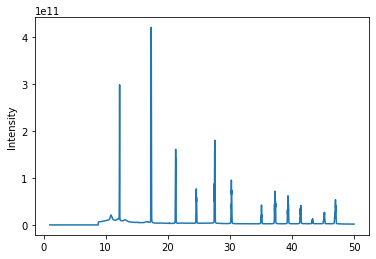

In [29]:
# Integrate the whole set of images in a single run:
angles = []
images = []
for sg in gonioref.single_geometries.values():
    angles.append(sg.get_position())
    images.append(sg.image)
#print(images)
print(angles)
multigeo = gonioref.get_mg(angles)
multigeo.radial_range=(1,50)
multigeo.unit=("2th_deg")
print(multigeo)

plt.figure()
res = multigeo.integrate1d(images, 10000)
fig, ax = plt.subplots()
ax.plot(*res)
#ax.set_xlabel(res.unit.label)
ax.set_ylabel("Intensity")


H:\Data\ProjectsandData\LiXRD\open cell\cone cell\20190329\LaB6\images\imgs


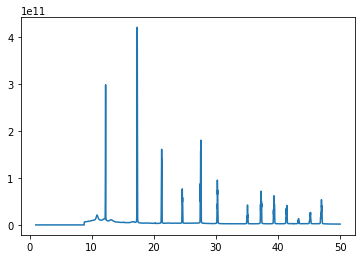

"df = pd.DataFrame(tth, i)\ndf.to_csv('LaB6_integration.csv')"

In [30]:
print(raw_alignment_folder)
#gonioref.save(raw_alignment_folder + "\\Lab6calib.json")


tth, i = multigeo.integrate1d(images, 10000)

plt.plot(tth, i)
plt.show()
"""df = pd.DataFrame(tth, i)
df.to_csv('LaB6_integration.csv')"""



# Conclusion

This notebook exposes the how to calibrate the goniometer for a detector moving on a 2theta arm. 
Once calibrated, the geometry can be saved and restored and stays valid as long as the detector or the goniometer is not unmounted from the beam-line. This configuration can subsequently be used to integrate the data acquired with any  sample, in minutes instead of hours. The resolution limit is now the pixel size.